<a href="https://colab.research.google.com/github/josedv82/sportsDraweR/blob/master/NBA_Schedule_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[XGBOOST](https://xgboost.readthedocs.io/en/latest/) PLAYGROUND**


---


## **Game Outcome Prediction Model Based on NBA Schedule Data**  
###Jose Fernandez




---



#1. Prepare packages and data

Load packages and split the dataset into train and test set for h2o

In [ ]:
#install required packages
install.packages(c("tidyverse", "h2o", "ggtext"))

In [ ]:
#load libraries and data
library(tidyverse)
library(h2o)

#20 seasons (2000-2019). The raw data was downloaded using the airball package in R. In addition, other metrics were calculated based on the raw data
#in this case the data is perfectly balanced, since each game provides two observations (winning and losing)
dat <- read.csv("https://www.dropbox.com/s/638fwmfr4o2q864/data_nba_sche.csv?dl=1") %>%
mutate(Result = as.factor(Result))

str(dat)

#for more info on how this data was collected visit: https://github.com/josedv82/airball

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from 

'data.frame':	51590 obs. of  50 variables:
 $ Season       : chr  "1999-00" "1999-00" "1999-00" "1999-00" ...
 $ Team         : chr  "Atlanta Hawks" "Atlanta Hawks" "Atlanta Hawks" "Atlanta Hawks" ...
 $ Opponent     : chr  "Washington Wizards" "Milwaukee Bucks" "Chicago Bulls" "Denver Nuggets" ...
 $ Date         : chr  "11/2/1999" "11/4/1999" "11/6/1999" "11/8/1999" ...
 $ Location     : int  1 0 0 1 1 1 1 0 1 0 ...
 $ Distance     : int  544 544 0 1203 1110 259 821 1941 427 427 ...
 $ Distance3    : int  544 1088 544 1203 2313 259 1080 2762 427 854 ...
 $ Distance5    : int  544 1088 1088 1747 2313 1369 2190 3021 2368 2795 ...
 $ Distance7    : int  544 1088 1088 2291 2857 2572 3393 4131 3448 3616 ...
 $ Distance9    : int  544 1088 1088 2291 3401 2572 3393 5334 3448 3875 ...
 $ Rest         : int  15 1 1 1 1 2 0 1 2 0 ...
 $ Zone         : int  0 0 0 -2 -1 0 0 3 0 0 ...
 $ Result       : Factor w/ 2 levels "0","1": 1 1 2 1 1 1 1 2 2 1 ...
 $ G3           : int  1 2 2 2 2 1 2 2 1 2 

In [ ]:
#start h2o cluster
h2o.init()

In [ ]:
#set target and features
target <- "Result"

#set predictors - removed features accounting for long (>10 days) periods
features <- setdiff(colnames(dat), 
c(target, "Season", "Team", "Opponent", "Date", "G11", "G13", "G15", "G17", "G19", "G21", 
          "Opp_G11", "Opp_G13", "Opp_G15", "Opp_G17", "Opp_G19", "Opp_G21"))
print(features) 

#all features used in the model accounting for multiple metrics for the team as well as the opponent for each game

# Distance Features: Cum distance travelled over different time windows 3d, 5d, etc..
# Shift Features: Sum of shifts (time zone changes) over different time windows 3d, 5d, etc...
# G Features: Sum of games played over different time windows 3d, 5d, etc...
# Rest: Number of rest days for a given day
# Zone: Time zone change for a given day
# Features starting with "Opp" refer to same metrics for opponents
# win_pct: win_pct for a given game

 [1] "Location"      "Distance"      "Distance3"     "Distance5"    
 [5] "Distance7"     "Distance9"     "Rest"          "Zone"         
 [9] "G3"            "G5"            "G7"            "G9"           
[13] "Shift3"        "Shift5"        "Shift7"        "Shift9"       
[17] "win_pct"       "Opp_Distance"  "Opp_Rest"      "Opp_Zone"     
[21] "Opp_G3"        "Opp_G5"        "Opp_G7"        "Opp_G9"       
[25] "Opp_Shift3"    "Opp_Shift5"    "Opp_Shift7"    "Opp_Shift9"   
[29] "Opp_Distance3" "Opp_Distance5" "Opp_Distance7" "Opp_Distance9"
[33] "opp_win_pct"  


Create train, validation and testing data

In [ ]:
#convert our df into a h2o df
h_data <- as.h2o(dat)
# split 70/15/15 train/validation and test dataset
h_split <- h2o.splitFrame(h_data, ratios = c(0.7, 0.15), seed = 42)
h_train <- h_split[[1]]
h_valid <- h_split[[2]]
h_test <- h_split[[3]]

  |======================================================================| 100%




---



#2. Model Hyperparameters
To help define the best parameters for our model, we can run a search to identify best model performance based on AUC. We'll search over as many models as possible during x number of seconds. This will help set up the model. 

*Only Run this part if you wish to explore other model parameters. The actual model I built below is already set*

In [ ]:
#create a grid of different parameters ranges. Will keep it simple for now to only a few parameters.
xgb_params <- list(learn_rate = seq(0.1, 0.3, 0.01), 
                   max_depth = seq(2, 10, 1),
                   subsample = seq(0.9, 1.0, 0.05),
                   col_sample_rate = seq(0.1, 1.0, 0.1))

#searching criteria. As many models as can be trained in x number of seconds (set for 10mins right now)
search_criteria <- list(strategy = "RandomDiscrete", max_runtime_secs = 600) 

#create the grid
xgb_grid <- h2o.grid("xgboost", x = features, y = target,
                      grid_id = "xgb_grid",
                      training_frame = h_train,
                      validation_frame = h_valid,
                      ntrees = 500, 
                      seed = 42,
                      hyper_params = xgb_params,
                      search_criteria = search_criteria)

#display the top models based on AUC
xgb_gridperf <- h2o.getGrid(grid_id = "xgb_grid", 
                             sort_by = "auc", 
                             decreasing = TRUE)
print(xgb_gridperf)

Check the best model on unseen data

In [ ]:
# Get the model id for the best identified model
best_xgb_model_id <- xgb_gridperf@model_ids[[1]]
best_xgb <- h2o.getModel(best_xgb_model_id)

# Evaluate model performance on unseen data for confirmation
best_xgb_perf <- h2o.performance(model = best_xgb, 
                                 newdata = h_test) 

paste("AUC:", round(h2o.auc(best_xgb_perf),3))

[1] "AUC: 0.801"



---



#3. Build the model

Creating the XGBoost model using the parameters from the best model detected on the previous step.

In [ ]:
# Build and train the xgboost model using the parameters from the best model identifies on previous step 
mod_xgb <- h2o.xgboost(x = features, y = target,
                           training_frame = h_train, 
                           validation_frame = h_valid,
                           booster = "gbtree",
                           eta = 0.11, 
                           max_depth = 2, 
                           gamma = 2,
                           subsample = 0.95,
                           ntrees = 500,
                           stopping_rounds = 1,
                           stopping_metric = "logloss",
                           seed = 42)

  |======================================================================| 100%




---



#4. Model Performance

Below are a few ways to look at the performance of this model.  
*AUC 0.8 | Accuracy 0.72*

In [ ]:
# Model Performance
perf <- h2o.performance(mod_xgb, h_valid)
perf

#max f1 threshold (from valid dataset) at 0.40. Anything above that will be predicted as 1 (win)

H2OBinomialMetrics: xgboost

MSE:  0.1817453
RMSE:  0.426316
LogLoss:  0.5374039
Mean Per-Class Error:  0.282103
AUC:  0.8012042
AUCPR:  0.8039165
Gini:  0.6024085
R^2:  0.2730132

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
          0    1    Error        Rate
0      2382 1448 0.378068  =1448/3830
1       709 3100 0.186138   =709/3809
Totals 3091 4548 0.282367  =2157/7639

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.413126    0.741893 231
2                       max f2  0.167837    0.846809 341
3                 max f0point5  0.571043    0.736439 166
4                 max accuracy  0.542151    0.726273 179
5                max precision  0.999810    1.000000   0
6                   max recall  0.009272    1.000000 395
7              max specificity  0.999810    1.000000   0
8             max absolute_mcc  0.547268    0.454373 177
9   max 

Plot the AUC curve on the unseen data

[1] "AUC: 0.801"


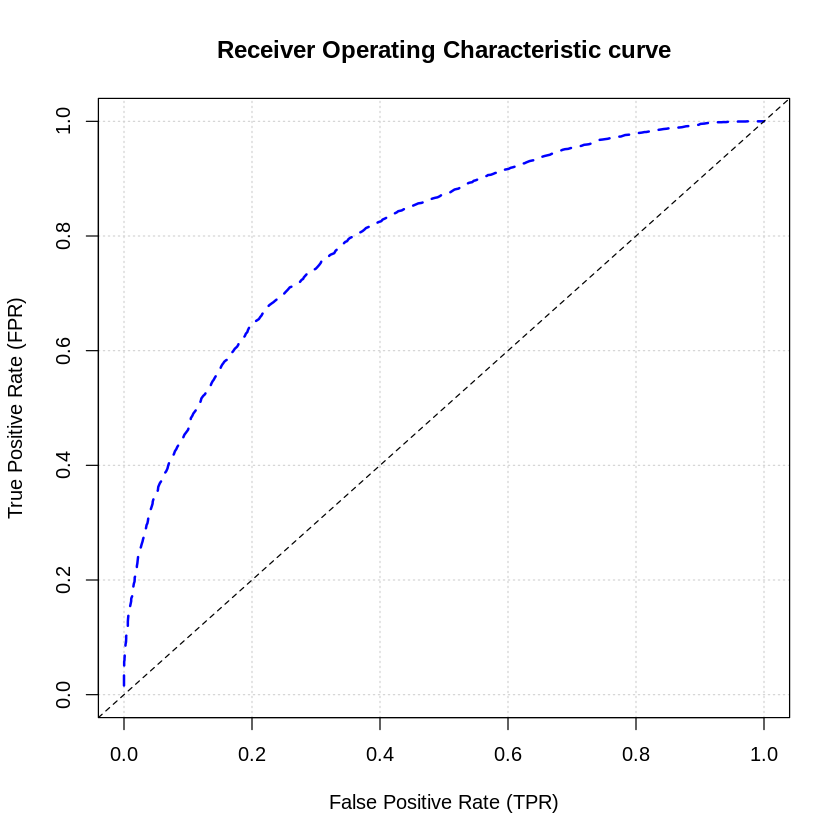

In [ ]:
# retrieve the AUC for the performance object:
print(paste("AUC:", round(h2o.auc(perf),3)))
plot(perf, type = "roc")

In [ ]:
# retrieve the AUC for both the training and validation data:
round(h2o.auc(mod_xgb, train = TRUE, valid = TRUE, xval = FALSE),3)

train valid 
0.811 0.801

Checking predictions from our model on unseen data. This will output a table of 20 random games, along with the actual and predicted results and the probabilities or winning an losing. 

To predict a win, probability of winning has to be above the f1 threshold of 0.42.

In [ ]:
# Generate predictions on unseen data
pred <- h2o.predict(mod_xgb, newdata = h_test)

# add team columns to predictions
preds <- as.data.frame(pred) %>% 
mutate(ID = row_number()) %>% 
select(ID, `Predicted Result` = predict, `Probability_0` = p0, `Probability_1` = p1)

test_dat <- as.data.frame(h_test) %>% 
select(Season, Date, Team, Opponent, Location, `Actual Result` = Result) %>% 
mutate(Location = ifelse(Location == 0, "Home", "Away")) %>%
mutate(ID = row_number())

tab <- full_join(test_dat, preds, by = "ID") %>% 
select(-ID) %>%
mutate(Guess = ifelse(`Actual Result` == `Predicted Result`, "Correct", "Wrong"),
       Probability_0 = round(Probability_0, 2),
       Probability_1 = round(Probability_1, 2))

# sample 20 games at random
tab[sample(nrow(tab), 20), ]

  |======================================================================| 100%


,Season,Date,Team,Opponent,Location,Actual Result,Predicted Result,Probability_0,Probability_1,Guess
,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<chr>
4818,2011-12,1/29/2012,Miami Heat,Chicago Bulls,Home,1,1,0.49,0.51,Correct
3714,2008-09,4/3/2009,Oklahoma City Thunder,Portland Trail Blazers,Home,0,0,0.77,0.23,Correct
5036,2012-13,4/5/2013,Charlotte Bobcats,Miami Heat,Home,0,0,0.91,0.09,Correct
6948,2016-17,1/7/2017,Toronto Raptors,Chicago Bulls,Away,0,1,0.43,0.57,Wrong
3061,2007-08,1/18/2008,Boston Celtics,Philadelphia 76ers,Home,1,1,0.09,0.91,Correct
1433,2002-03,1/20/2003,Portland Trail Blazers,Memphis Grizzlies,Away,1,1,0.25,0.75,Correct
4535,2010-11,2/22/2011,Oklahoma City Thunder,Los Angeles Clippers,Home,1,1,0.16,0.84,Correct
6787,2016-17,12/18/2016,Miami Heat,Boston Celtics,Home,0,0,0.69,0.31,Correct
5904,2014-15,12/10/2014,Houston Rockets,Golden State Warriors,Away,0,0,0.88,0.12,Correct




---



#5. Model Explainability with SHAP values

Since this is a blackbox model, it is important to find ways to explain the outcome so that the users of this model can make changes related to the features we are accounting for. For example, if we know that distance traveled in the last 7 days is important, we may try and optimise our travel options.

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature.

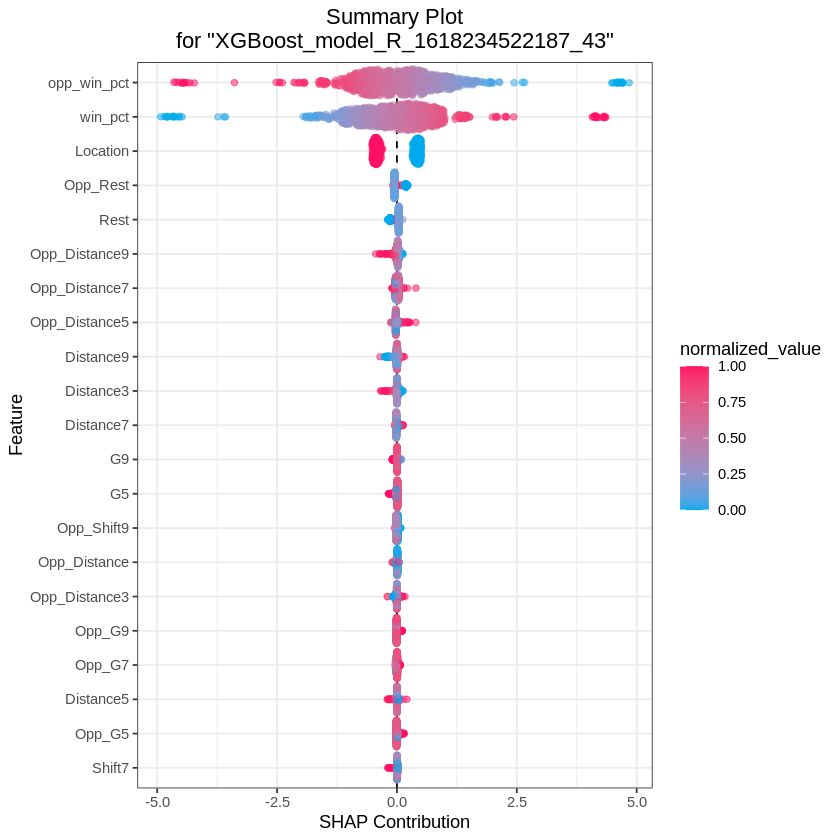

In [ ]:
#shap explanation for the model. at the top more important features. Pink colors contrinute to winning
shap_summary_plot <- h2o.shap_summary_plot(mod_xgb, h_test)
print(shap_summary_plot)

#Not surprising, Opp_Win_Pct, win_pct, game location and Rest for both the team and the opponent are the most important features.

## Explaining individual observations (games)

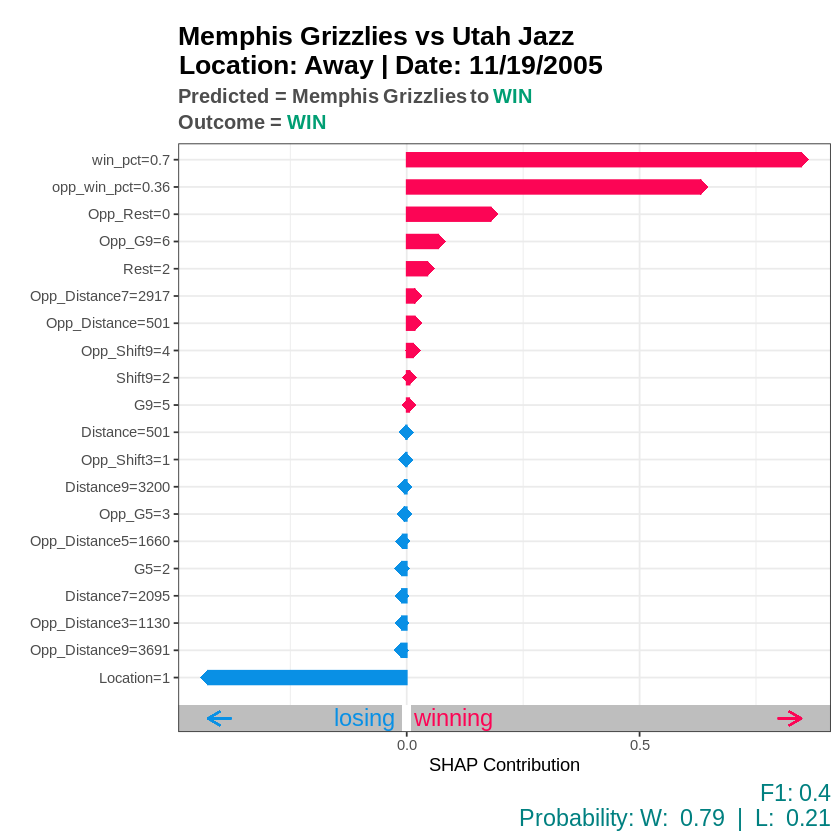

In [ ]:
#shap (force plot) explanation for one observation o the test data. Change row index between 0-7777 to pick another game

#parameters for plot
row_index <- sample(0:7777, 1) #sample random game from the test dataset every time this chunk is run
df <- as.data.frame(h_test[row_index,])
probs <- tab[row_index,]
Team <- df$Team
Opponent <- df$Opponent
Location <- if (df$Location == 1) {"Away"} else {"Home"}
Date <- df$Date
Result <- if (df$Result == 0) {"<span style='color:darkred;'>LOSS</span>"} else {"<span style='color:#009E73;'>WIN</span>"}

#shap plot object
shap_ind_row <- h2o.shap_explain_row_plot(mod_xgb, h_test, row_index = row_index) # on test dataset

#extract prediction (0 or 1)
Prediction <- if (sub(".*: ", "", shap_ind_row$labels$title) == "0") {"<span style='color:darkred;'>LOSE</span>"} else {"<span style='color:#009E73;'>WIN</span>"}
shap_ind_row$layers[[1]]$aes_params$fill <- NULL

#enhance the final shap force plot
shap_ind_row +
annotate("rect", ymin = -Inf, ymax = Inf, xmin = -1, xmax = 0, fill = "grey") +
annotate("rect", ymin = -0.01, ymax = 0.01, xmin = -1, xmax = 0, fill = "white") +
annotate("text", y = 0.1, x = -0.45, label = "winning", color = "#fc0555", size = 5) +
annotate("text", y = -0.09, x = -0.45, label = "losing", color = "#0990e5", size = 5) +
annotate("text", y = 0, x = -1, label = ".", color = "white") +
aes(fill = contribution < 0, color = contribution < 0, width = 0.5) + 
geom_point(shape = 18, size = 4) +
scale_fill_manual(values = c("TRUE" = "#0990e5", "FALSE" = "#fc0555")) +
geom_segment(aes(x = -0.5, y = max(contribution) - 0.05, xend = -0.5, yend = max(contribution)), arrow = arrow(length = unit(0.3, "cm")), color = "#fc0555") +
geom_segment(aes(x = -0.5, y = min(contribution) + 0.05, xend = -0.5, yend = min(contribution)), arrow = arrow(length = unit(0.3, "cm")), color = "#0990e5") +
scale_color_manual(values = c("TRUE" = "#0990e5", "FALSE" = "#fc0555")) +
labs(title = paste("", Team, "vs", Opponent, "\n", "Location:", Location, "| Date:", Date, sep = " "),
     subtitle = paste("Predicted =", df$Team, "to ", Prediction, "<br>", "Outcome = ", Result),
     caption = paste("F1: 0.4\n","Probability:", "W: ", probs$Probability_1, " | ", "L: ", probs$Probability_0),
     x = "") +
theme(plot.title = element_text(size = 16, hjust = -0.03, face = "bold"),
      plot.subtitle = ggtext::element_markdown(size = 12, lineheight = 1.3, face = "bold", color = "grey30"),
      plot.caption = element_text(size = 14, color = "#008080"),
      legend.position = "none")

# 6. Predictions on 2021 Season

Our model was trained with data from the 2000-19 seasons. Here we will run it on 2021 data. 

The following code outputs a table with predictions for the 2021 games that have been played as well as the remaining ones (as of 4/6/21).

*Use the filter on the right to view the 2021 predictions for specific teams.*

In [ ]:
#@title Select a team { run: "auto", form-width: "20%" }
Team1 <- "Los Angeles Lakers" #@param ["Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets", "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets", "Detroit Pistons", "Golden State Warriors", "Houston Rockets", "Indiana Pacers", "Los Angeles Clippers", "Los Angeles Lakers", "Memphis Grizzlies", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans", "New York Knicks", "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers", "Phoenix Suns", "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Toronto Raptors", "Utah Jazz", "Washington Wizards"]

#load 2021 season data downloaded from Airball package
dat21 <- read.csv("https://www.dropbox.com/s/w36wzv1ohyhagql/data_nba_sche_2021.csv?dl=1") %>% mutate(ID = row_number())

#remove columns not used for modeling
dat21_mod <- dat21 %>% select(-Season, -Team, -Opponent, -Date, -G11, -G13, -G15, -G17, -G19, -G21, -Opp_G11, -Opp_G13, -Opp_G15, -Opp_G17, -Opp_G19, -Opp_G21)

h_dat21_mod <- as.h2o(dat21_mod)

# Generate predictions on unseen data
pred21 <- h2o.predict(mod_xgb, newdata = h_dat21_mod)

# add games columns fro daw data set to predictions
preds21 <- as.data.frame(pred21) %>% 
mutate(ID = row_number()) %>% 
select(ID, `Predicted Result` = predict, `Probability_0` = p0, `Probability_1` = p1)

test_dat <- dat21 %>% 
select(Season, Date, Team, Opponent, Location, `Actual Result` = Result) %>% 
mutate(Location = ifelse(Location == 0, "Home", "Away")) %>%
mutate(ID = row_number())

tab <- full_join(test_dat, preds21, by = "ID") %>% 
select(-ID) %>%
mutate(Guess = ifelse(`Actual Result` == `Predicted Result`, "Correct", "Wrong"),
       Probability_0 = round(Probability_0, 2),
       Probability_1 = round(Probability_1, 2)) %>%
mutate(`Actual Result` = ifelse(is.na(`Actual Result`), "Not Played", `Actual Result`)) %>%
mutate(Guess = ifelse(is.na(Guess), "?", Guess))


# Output final table by team
tab %>% filter(Team == Team1)

# or by date
#tab %>% filter(Date == "2021-04-11")


  |======================================================================| 100%
  |======================================================================| 100%


Season,Date,Team,Opponent,Location,Actual Result,Predicted Result,Probability_0,Probability_1,Guess
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>
2020-21,2020-12-22,Los Angeles Lakers,Los Angeles Clippers,Home,0,0,1.00,0.00,Correct
2020-21,2020-12-25,Los Angeles Lakers,Dallas Mavericks,Home,1,1,0.00,1.00,Correct
2020-21,2020-12-27,Los Angeles Lakers,Minnesota Timberwolves,Home,1,1,0.37,0.63,Correct
2020-21,2020-12-28,Los Angeles Lakers,Portland Trail Blazers,Home,0,0,0.67,0.33,Correct
2020-21,2020-12-30,Los Angeles Lakers,San Antonio Spurs,Away,1,1,0.47,0.53,Correct
2020-21,2021-01-01,Los Angeles Lakers,San Antonio Spurs,Away,1,1,0.32,0.68,Correct
2020-21,2021-01-03,Los Angeles Lakers,Memphis Grizzlies,Away,1,1,0.21,0.79,Correct
2020-21,2021-01-05,Los Angeles Lakers,Memphis Grizzlies,Away,1,1,0.20,0.80,Correct
2020-21,2021-01-07,Los Angeles Lakers,San Antonio Spurs,Home,0,1,0.19,0.81,Wrong


## Evaluate which teams are over / under performing the model.

**n_over:** Number of times a team won when the model predicted losing.  
**n_under:** Number of times a taem lost when the model predicted winning.

In [ ]:
# Table for 1 on 0 (over performing)
over <- tab %>% 
filter(Guess != "?") %>%
filter(`Actual Result` == 1 & `Predicted Result` == 0) %>%
group_by(Team) %>%
summarise(n_over = n()) %>%
arrange(-n_over)

# Table for 0 on 1 (under performing)
under <- tab %>%
filter(Guess != "?") %>%
filter(`Actual Result` == 0 & `Predicted Result` == 1) %>%
group_by(Team) %>%
summarise(n_under = n()) %>%
arrange(-n_under)

# join both over / under tables
full_join(over, under, by = "Team") %>% 
arrange(-n_over) #switch to n_under to sort by teams under performing.

Team,n_over,n_under
<chr>,<int>,<int>
Washington Wizards,13,4
Detroit Pistons,11,1
Minnesota Timberwolves,9,4
New Orleans Pelicans,9,12
Dallas Mavericks,7,10
Memphis Grizzlies,7,10
Miami Heat,7,9
Oklahoma City Thunder,7,11
Toronto Raptors,7,9




---



#7. Model Benchmarking
We should bench mark our model against other options. 

That's beyond this notebook but here is an example on how to get started with this within the H2o framework.

In [ ]:
# Build several ml models for comparison. Added basic param. This could be further tuned to compare performance across models.
# This will take around 45-50mins with current specs. Adjust max_run_time for shorter times if needed
automl <- h2o.automl(x = features,
                    y = target,
                    training_frame = h_train,
                    nfolds = 5,     
                    max_models = 30,
                    stopping_metric = "logloss",
                    project_name = "automl_nba_schedule",
                    sort_metric = "logloss",
                    seed = 42)

Finally, we can plot or the models and check some performance metrics. It looks like our model did well compared to other models.

In [ ]:
# create model leaderboard from all the above models
mod_leaderboard <- as.data.frame(automl@leaderboard) %>% 
mutate(logloss = round(logloss, 2),
       auc = round(auc,3),
       aucpr = round(aucpr,3),
       mean_per_class_error = round(mean_per_class_error,3),
       rmse = round(rmse,3),
       mse = round(mse,3))

# display leaderboard. (Top model is a GLM)
mod_leaderboard

# stop here for now

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLM_1_AutoML_20210403_191429,0.54,0.801,0.798,0.300,0.427,0.182
StackedEnsemble_AllModels_AutoML_20210403_191429,0.54,0.801,0.799,0.297,0.427,0.183
DeepLearning_grid__3_AutoML_20210403_191429_model_1,0.54,0.798,0.795,0.300,0.428,0.183
DeepLearning_grid__2_AutoML_20210403_191429_model_1,0.54,0.799,0.795,0.297,0.428,0.183
StackedEnsemble_BestOfFamily_AutoML_20210403_191429,0.54,0.801,0.799,0.300,0.427,0.183
XGBoost_3_AutoML_20210403_191429,0.54,0.796,0.795,0.301,0.429,0.184
GBM_1_AutoML_20210403_191429,0.54,0.797,0.795,0.295,0.429,0.184
XGBoost_grid__1_AutoML_20210403_191429_model_9,0.54,0.795,0.793,0.299,0.430,0.185
GBM_grid__1_AutoML_20210403_191429_model_1,0.54,0.796,0.793,0.296,0.429,0.184




---



#8. Conclusion



*   We started by imported data from the 2000-19 season downloaded with the [Airball package](https://github.com/josedv82/airball) in R. 
*  Then, we intalled the libraries, load the packages and the data. We also did some minor data preparation like turning the target column into a factor.
* After that, we split the data into training, validation and testing.
* Then we did some minor parameter serarch to identify the model with the best performance based on AUC metric.
* We used that to guide the parameter tuning process while building the xgboost model on our train and validation dataset. 
* We checked the performance of the model, in different ways, like checking AUC on train and validation datasets and plotting the AUC curve (0.80) on unseen data.
* After this, we did some model explainability using SHAP values. We found that winning percentages, location and rest where the most influencial metrics. While winning % is not a schedule related metric, it accounts for team quality and helps calibrate the results.
* Also, force plots like visualizations allowed us to understand predictions for one observation and how each feature influence the result. 
* We run the model on new 2021 season data and build a widget to view predictions for different teams, for both past and future games in the current season.
* We tried to undrstand which teams were under or over performing the model prediction.
* Finally, we touched on model benchmarking with autoML fromthe H2O framework and found our model performed well compared to other models. 





---



#9. References



*   Molnar, C. (2021). Interpretable Machine Learning. A guide for making black box models explainable. [Link](https://christophm.github.io/interpretable-ml-book/shap.html)
*   Fernandez, J. (2020). airball: Schedule & Travel Related Metrics in Basketball. R package version 0.4.0. [Link](https://github.com/josedv82/airball)
* Chen, T. and Carlos Guestrin. (2016). “XGBoost: A Scalable Tree Boosting System.” Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. [Link](https://arxiv.org/abs/1603.02754)
* XGBoost Documentation [Link](https://xgboost.readthedocs.io/en/latest/#)
* H2O.ai Documentation Site [Link](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/faq/r.html)

